<h1 style="font-size:30px;">Image Super Resolution</h1> 

Super Resolution refers to the process of upscaling or increasing the resolution of an image. When increasing the dimensions of an image, the extra pixels need to be interpolated. Basic interpolation techniques do the job pretty well. But in many cases where the image itself is of low quality, they do not produce realistic results. This is because they do not take the surrounding context into account while upscaling the image. Deep learning techniques developed since 2016 have demonstrated improved performance over traditional interpolation methods. In this notebook, we will explore the deep learning-based methods available in OpenCV for performing Super Resolution on images.

<br>
<center>
<img src='https://opencv.org/wp-content/uploads/2021/10/c0-m20-feature-image-super-resolution.png' alt='feature-image-super-resolution'>
</center>
<br>

# <font style="color:black">Super Resolution Benchmarking</font>

The following plot from [Deep Learning for Image Super-resolution:
A Survey](https://arxiv.org/pdf/1902.06068.pdf) does a nice job of summarizing the recent research in this area by quantifying the image reconstruction quality (PSNR), number of operations (Billions), and model complexity in terms of the number of parameters (Millions).


<br>
<center>
<img src='https://opencv.org/wp-content/uploads/2021/10/c0-m20-Super-Resolution-Benchmarking.png' alt='super-resolution-benchmarking'>
</center>
<br>

# <font style="color:black">Super Resolution in OpenCV</font>


OpenCV comes with the following super resolution methods. All of them are Deep Learning based models.

1. [FSRCNN (Accelerating the Super-Resolution Convolutional Neural Network)](https://arxiv.org/pdf/1608.00367.pdf) - released in ECCV 2016
2. [ESPCN (Real-Time Single Image and Video Super-Resolution Using an Efficient Sub-Pixel Convolutional Neural Network)](https://arxiv.org/pdf/1609.05158.pdf) - released in CVPR 2016
4. [EDSR (Enhanced Deep Residual Networks for Single Image Super-Resolution)](https://arxiv.org/pdf/1707.02921.pdf) - released in CVPR 2017 
3. [LAPSRN (Fast and Accurate Image Super-Resolution with Deep Laplacian Pyramid Networks)](https://arxiv.org/pdf/1710.01992.pdf) - released in CVPR 2017


The basic usage for performing Super Resolution in OpenCV is as follows:


### <font color="green">Function Syntax</font>

```Python

# Create super-resolution object.
obj = cv2.dnn_superres.DnnSuperResImpl_create()

# Path to the model.
obj.readModel(modelPath)

# Specify the method (one of "fsrcnn", "espcn", "lapsrn", "edsr") and scale.
obj.setModel(method, scale)

# Perform Upsampling
obj.upsample(image)
```

`scale`: The upsampling ratio with type int. Output image will be upsampled scale times.

The models for different methods can be found from below links:

1. [FSRCNN](https://github.com/Saafke/FSRCNN_Tensorflow/tree/master/models)
2. [ESPCN](https://github.com/fannymonori/TF-ESPCN/tree/master/export)
3. [LapSRN](https://github.com/fannymonori/TF-LapSRN/tree/master/export)
4. [EDSR](https://github.com/Saafke/EDSR_Tensorflow/tree/master/models)

### <font color="green">OpenCV Documentation</font>

[**`Super Resolution`**](https://docs.opencv.org/4.5.3/d9/de0/group__dnn__superres.html)

In [ ]:
if 'google.colab' in str(get_ipython()):
    print("Downloading Code to Colab Environment")
    !wget https://www.dropbox.com/sh/cc26mzjh77bgmg1/AAAYOQzNN8yvjBxLtjYDegh9a?dl=1 -O module-code.zip -q --show-progress
    !unzip -qq module-code.zip
    !pip install --upgrade opencv-contrib-python
else:
    pass

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from numpy import ndarray
import time
from IPython.display import Image
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 18

# 1. Preview Test Image

Let's start by loading a hi-res version of the OpenCV logo (256 x 256). We will then re-size that down to (64 x 64) to create a low res version, and we wil also crop a small portion of the low-res version around the 'O.' These low res versions will become test images to show how super resolution algorithms can improve upon the quality of upsampled images when compared to standard interpolation techniques.

In [2]:
# Read a hi-res version of the logo.
logo_high = cv2.imread('opencv-logo.png')
   
# Downsize the hi-res logo.
logo_low = cv2.resize(logo_high, (64,64), interpolation=cv2.INTER_AREA)

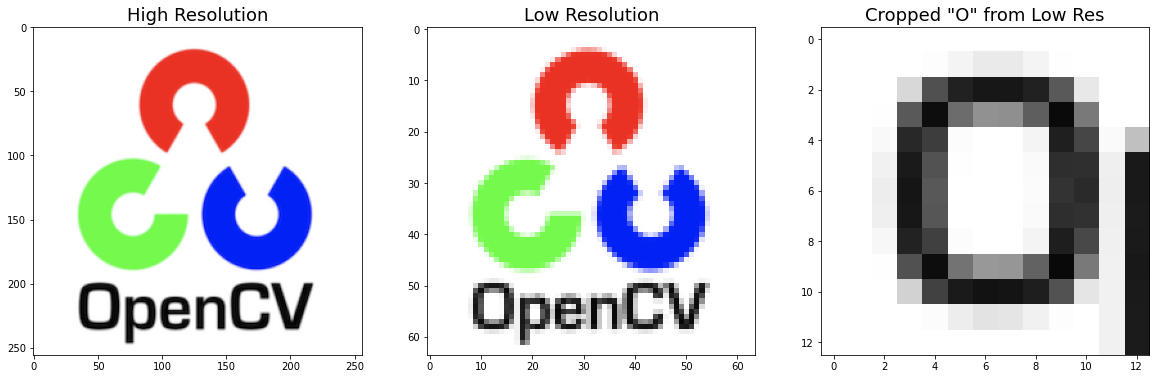

In [3]:
plt.figure(figsize=[20,8])
plt.subplot(131); plt.imshow(logo_high[:,:,::-1]);            plt.title('High Resolution')
plt.subplot(132); plt.imshow(logo_low[:,:,::-1]);             plt.title('Low Resolution')
plt.subplot(133); plt.imshow(logo_low[48:61,6:19][:,:,::-1]); plt.title('Cropped "O" from Low Res');

# 2. Upsample Using the Resize Function Bi-Cubic Algorithm

Let's first try upsampling the logo and the cropped region using bi-cubic interpolation. As you can see the upsampling using interpolation works pretty well, but there are still pixelated artifacts that are revealed in the upsampled image. For example, the upsampled images still look "boxy" (notice the corners of the "O" are not smooth, but rather still retain a pixelated look).

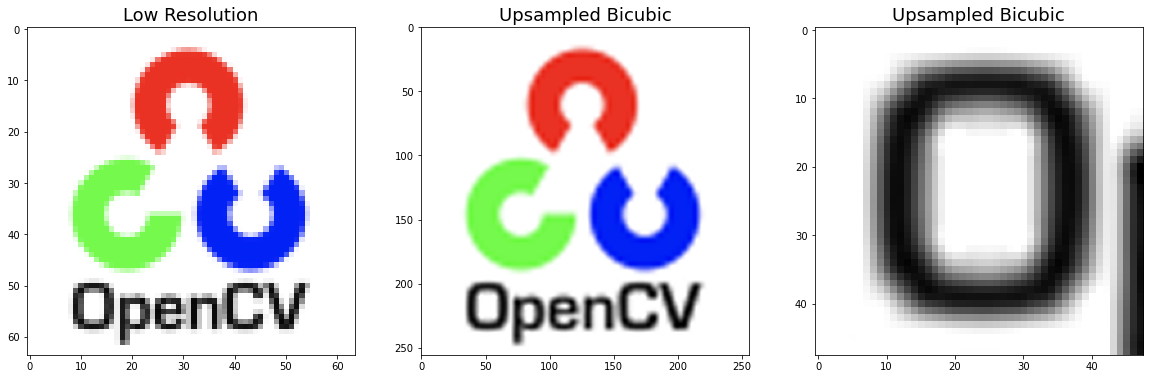

In [4]:
# Upsample the test images using bi-cubic interpolation.
result_bicubic = cv2.resize(logo_low, None, fx=4, fy=4, interpolation=cv2.INTER_CUBIC)


# Specify the ROI for the 'O'
roi_y = slice(194,242,1)
roi_x = slice(27,75,1)

plt.figure(figsize=[20,10]); 
plt.subplot(131); plt.imshow(logo_low[:,:,::-1]);                    plt.title('Low Resolution')
plt.subplot(132); plt.imshow(result_bicubic[:,:,::-1]);              plt.title('Upsampled Bicubic')
plt.subplot(133); plt.imshow(result_bicubic[roi_y,roi_x][:,:,::-1]); plt.title('Upsampled Bicubic');

# 3. Super Resolution Methods

In this section, we will produce results for each of the four super resolution models available in OpenCV. We begin by creating a super resolution object, that will be used in each section below.

### <font style="color:rgb(50,120,230)">Create a super resolution object<font/>

In [5]:
sr = cv2.dnn_superres.DnnSuperResImpl_create()

## 3.1 Super Resolution using FSRCNN

<br>
<center>
<img src='https://opencv.org/wp-content/uploads/2021/10/c0-m20-fsrcnn-diagram.png' alt='fsrcnn-diagram'>
</center>
<br>

FSRCNN and ESPCN have very similar concepts. Both of them have their base structure inspired by SRCNN and employ upscaling layers at the end for speed instead of interpolating it early on. Furthermore, they even shrink the input feature dimension and use smaller filter sizes before finally using more mapping layers, which results in the model being even smaller and faster.

The architecture starts with convolutional layers, with its filter size dropping to 5 from the 9 of SRCNN. Shrinking layers are applied as the input resolution itself can be huge and take much time. A filter size of 1×1 is used, which does not increase the computational cost.

The authors next focus on reducing the non-linear mapping that plays an integral part in slowing down the model without compromising accuracy. Hence, they use multiple 3×3 filters. The next expanding section is the opposite of the shrinking section, before finally applying deconvolutional layers for upsampling. For the activation function, PReLu was used.

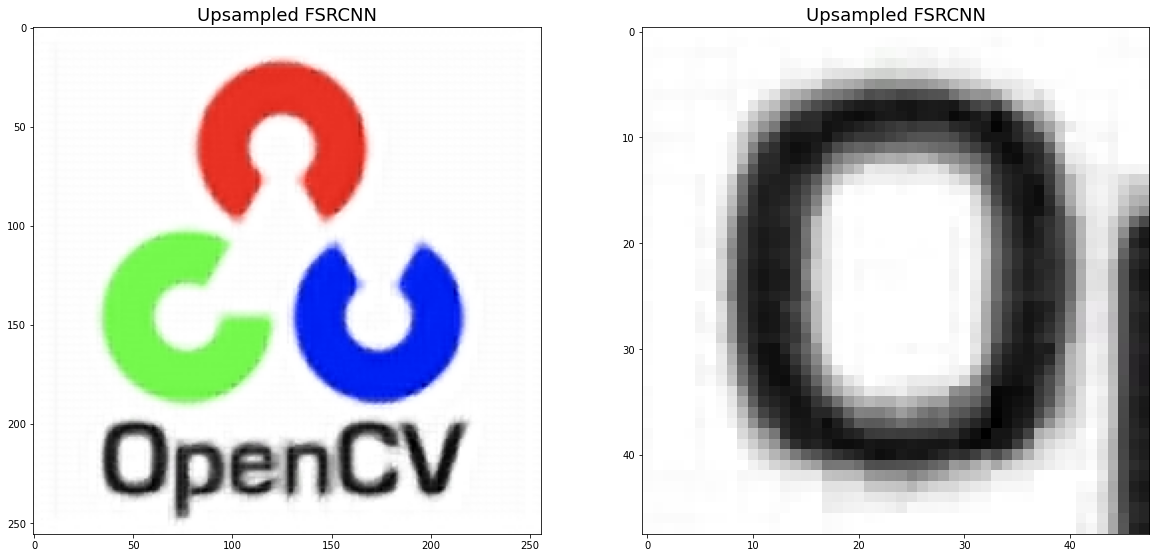

In [6]:
# Read the model.
sr.readModel('./models/FSRCNN_x4.pb')

# Set the model by passing the method and the upsampling scale factor.
sr.setModel('fsrcnn', 4) 

# Upscale the input image.
result_FSRCNN = sr.upsample(logo_low)

plt.figure(figsize=[20,10])
plt.subplot(121); plt.imshow(result_FSRCNN[:,:,::-1]);              plt.title('Upsampled FSRCNN')
plt.subplot(122); plt.imshow(result_FSRCNN[roi_y,roi_x][:,:,::-1]); plt.title('Upsampled FSRCNN');

## 3.2 Super Resolution using ESPCN

<br>
<center>
<img src='https://opencv.org/wp-content/uploads/2021/10/c0-m20-espcn-diagram.png' alt='espcn-diagram'>
</center>
<br>

Instead of performing super-resolution after upscaling the low resolution using a bicubic filter, Shi et al. extract feature maps in the low resolution itself and use complex upscaling filters to get the result. The upscaling layers are only deployed at the end of the network. This ensures that the complex operations occurring in the model happen on lower dimensions, which makes it fast, especially compared to other techniques.

The base structure of ESPCN is inspired by SRCNN. Instead of using the customary convolution layers, sub-pixel convolution layers are utilized, which act like deconvolution layers. The sub-pixel convolution layer is utilized in the last layer to produce the high-resolution map. Along with this, they found that the Tanh activation function works much better than the standard ReLu function.

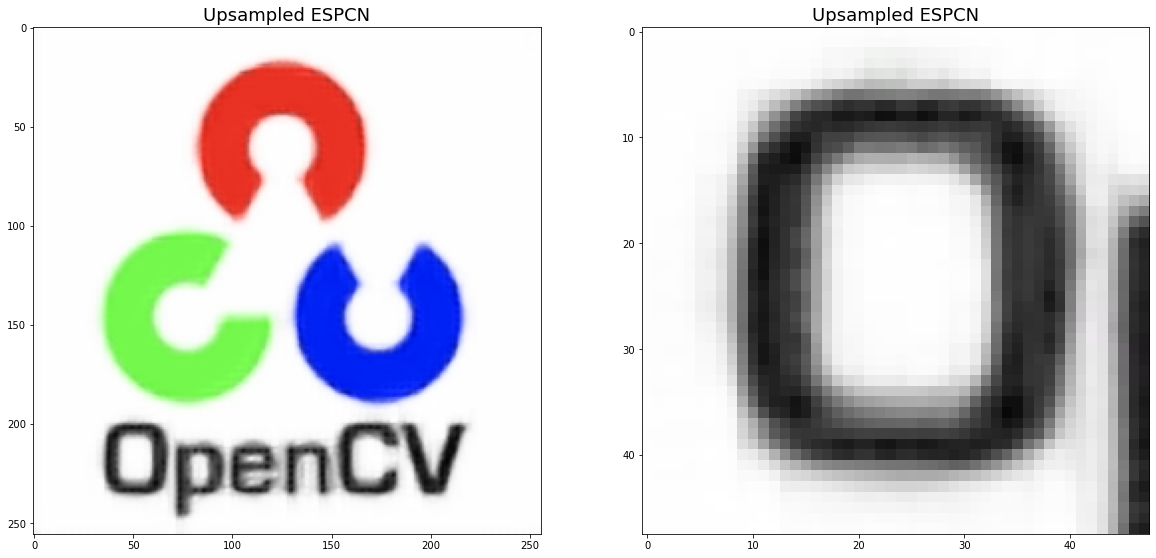

In [7]:
# Read the model.
sr.readModel('./models/ESPCN_x4.pb')

# Set the model by passing the method and the upsampling scale factor.
sr.setModel('espcn', 4) 

# Upscale the input image.
result_ESPCN = sr.upsample(logo_low)

plt.figure(figsize=[20,10])
plt.subplot(121); plt.imshow(result_ESPCN[:,:,::-1]);              plt.title('Upsampled ESPCN');
plt.subplot(122); plt.imshow(result_ESPCN[roi_y,roi_x][:,:,::-1]); plt.title('Upsampled ESPCN');

## 3.3 Super Resolution using LapSRN
<br>
<center>
<img src='https://opencv.org/wp-content/uploads/2021/10/c0-m20-lapsrn-diagram.png' alt='lapsrn-diagram.png'>
</center>
<br>
LapSRN offers a middle ground between the contrasting strategies of upscaling at the start and end. It proposes to upscale gently till the end. Its name is based on Laplacian pyramids, and the architecture is basically like a pyramid upscaling the lower resolution image until the end. For speed, parameter sharing is heavily relied on; and just like the EDSR models, they also proposed a single model that can reconstruct different scales calling it MS-LapSRN. However, OpenCV implements only LapSRN.

The models consist of two branches: feature extraction and an image reconstruction branch. Parameter sharing occurs among the different scales, i.e., 4x uses parameters from 2x model and so on. This means that one pyramid is used for scaling 2x, two for 4x, and three for 8x! Making such deep models means they can suffer from gradient vanishing problems. So they try different types of local skip connections like distinct-source skip connections and shared-source connections. Charbonnier loss is used for the model’s loss function, and batch normalization layers are not used.

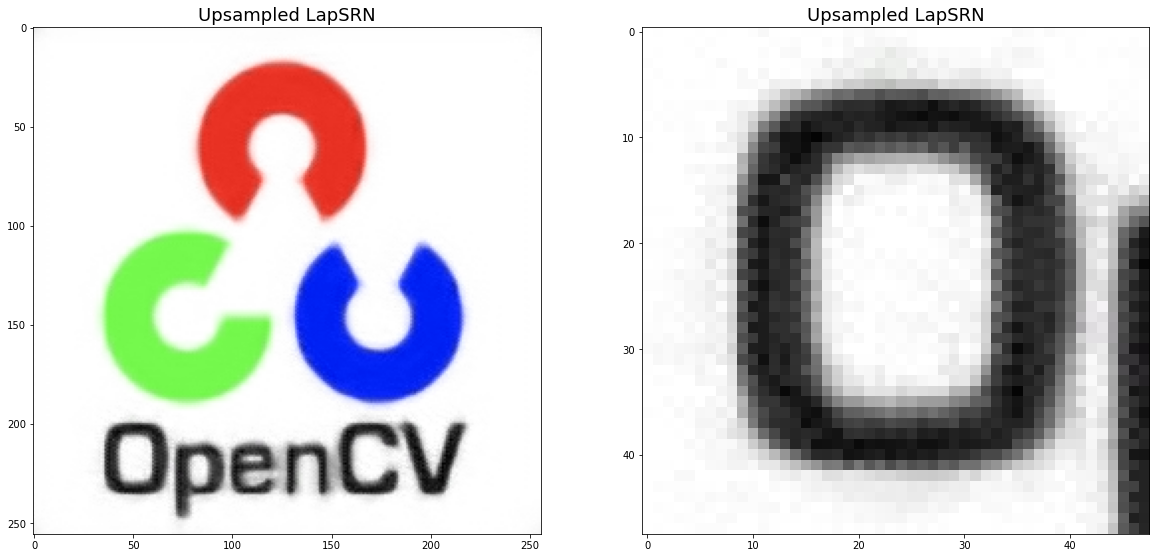

In [8]:
# Read the model.
sr.readModel('./models/LapSRN_x4.pb')

# Set the model by passing the method and the upsampling scale factor.
sr.setModel('lapsrn', 4) 

# Upscale the input image.
result_LapSRN = sr.upsample(logo_low)

plt.figure(figsize=[20,10])
plt.subplot(121); plt.imshow(result_LapSRN[:,:,::-1]);              plt.title('Upsampled LapSRN')
plt.subplot(122); plt.imshow(result_LapSRN[roi_y,roi_x][:,:,::-1]); plt.title('Upsampled LapSRN'); 

## 3.4 Super Resolution Using EDSR

This object instance will be used throughout the notebook

<br>
<center>
<img src='https://opencv.org/wp-content/uploads/2021/10/c0-m20-edsr-diagram.png' alt='edsr-diagram.png'>
</center>
<br>
Lim et al. proposed two methods in their paper, EDSR, and MDSR. Different models are required for different scales in the EDSR method. In comparison, a single model can reconstruct various scales in the MDSR model. OpenCV only implements EDSR.

A ResNet style architecture is used without the Batch Normalization layers. They found that those layers get rid of range flexibility from the features’ networks, improving the performance. This allows them to build a larger model with better performance. To counter the instability found in large models, they used residual scaling with a factor of 0.1 in each residual block by placing constant scaling layers after the last convolutional layers. Also, ReLu activation layers are not used after the residual blocks.

The architecture is initially employed for a scaling factor of 2. Then these pre-trained weights are used when training for a scaling factor of 3 and 4. This not only accelerates the training but also improves the performance of the models.

Let's have a look at an example

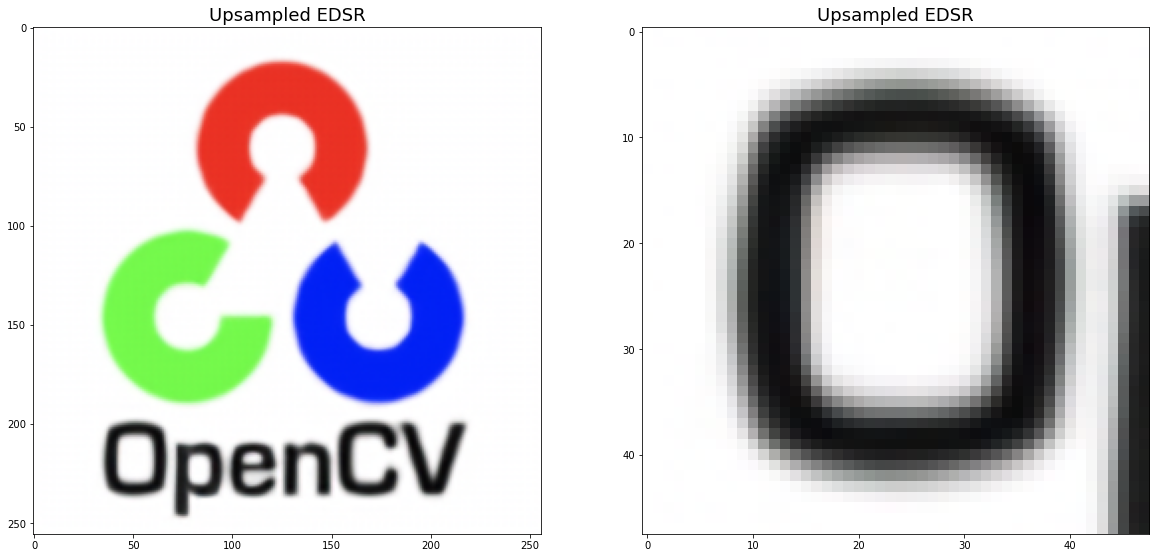

In [9]:
# Read the model.
sr.readModel('./models/EDSR_x4.pb')

# Set the model by passing the method and the upsampling scale factor.
sr.setModel('edsr', 4) 

# Upscale the input image.
result_EDSR = sr.upsample(logo_low)

plt.figure(figsize=[20,10])
plt.subplot(121); plt.imshow(result_EDSR[:,:,::-1]);              plt.title('Upsampled EDSR')
plt.subplot(122); plt.imshow(result_EDSR[roi_y,roi_x][:,:,::-1]); plt.title('Upsampled EDSR');

# 4. Compare Results

In this section we will compare the various upsampling methods. **It is important to remember that when comparing the quality of the upsampled images the images shoud be of the same resolution.** In the comparison grids below we start with the low resolution image in the upper left corner only to show it as the input. All the other images have been upsampled by a scale factor of 4. They are therefore four times larger than the input image even though we are plotting them below on the sampe physical scale as the input image. In this comparison grid we are only interested in comparing the upsampled images to each other in order to assess the characteristics of each algorithm.

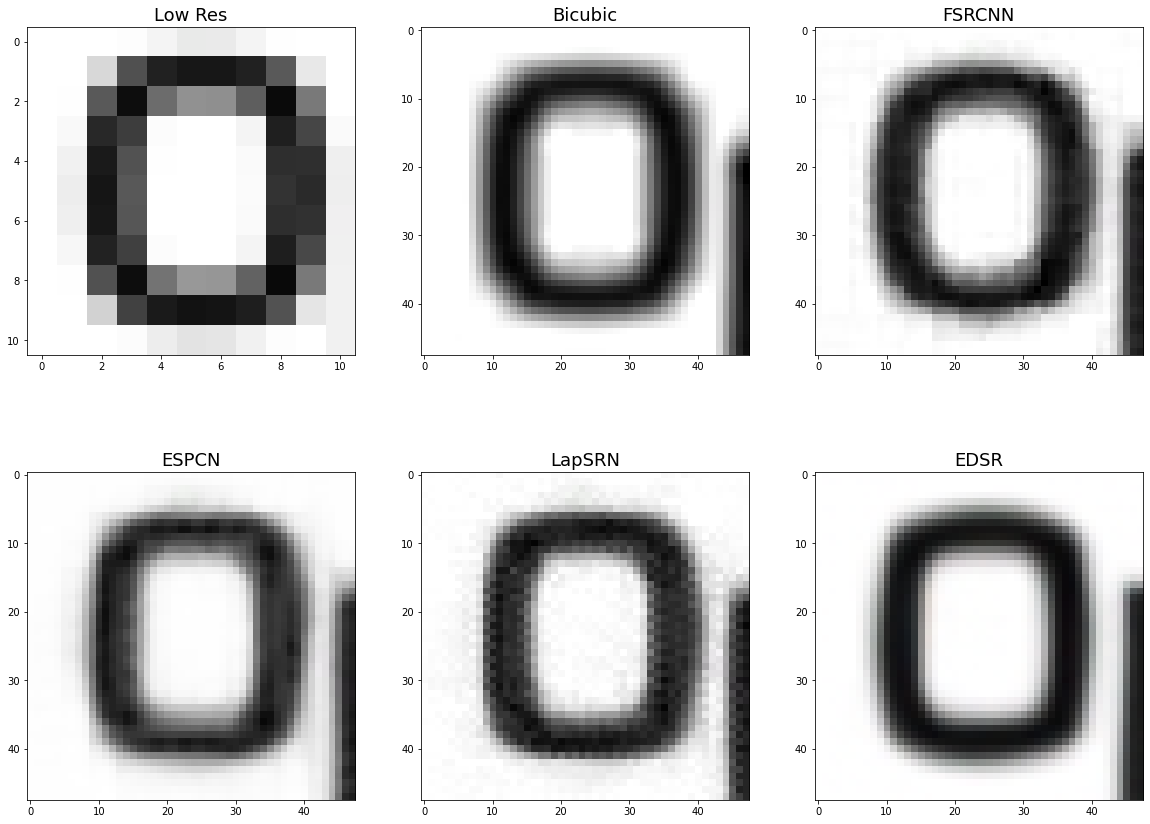

In [10]:
plt.figure(figsize=[20,15])
plt.subplot(231); plt.imshow(logo_low[49:60,7:18][:,:,::-1]);        plt.title('Low Res')
plt.subplot(232); plt.imshow(result_bicubic[roi_y,roi_x][:,:,::-1]); plt.title('Bicubic')
plt.subplot(233); plt.imshow(result_FSRCNN [roi_y,roi_x][:,:,::-1]); plt.title('FSRCNN')
plt.subplot(234); plt.imshow(result_ESPCN  [roi_y,roi_x][:,:,::-1]); plt.title('ESPCN')
plt.subplot(235); plt.imshow(result_LapSRN [roi_y,roi_x][:,:,::-1]); plt.title('LapSRN')
plt.subplot(236); plt.imshow(result_EDSR   [roi_y,roi_x][:,:,::-1]); plt.title('EDSR');

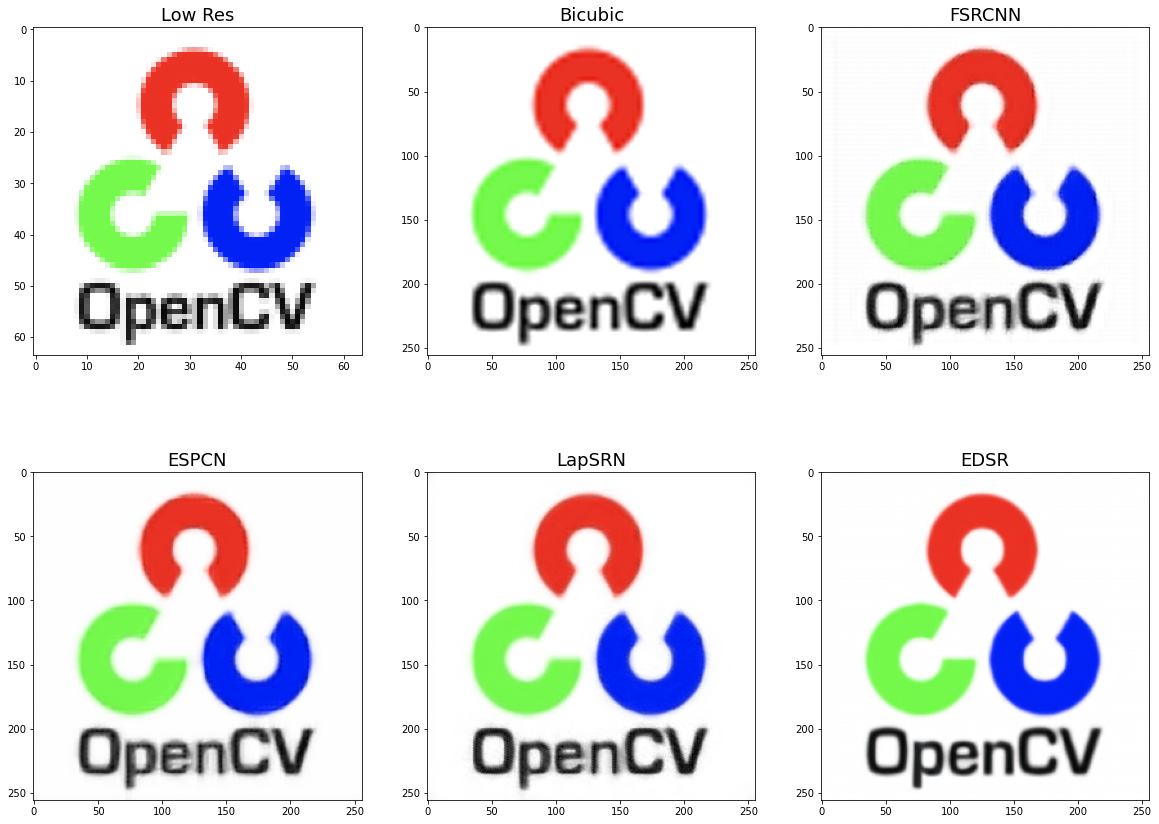

In [11]:
plt.figure(figsize=[20,15])
plt.subplot(231); plt.imshow(logo_low[:,:,::-1]);       plt.title('Low Res')
plt.subplot(232); plt.imshow(result_bicubic[:,:,::-1]); plt.title('Bicubic')
plt.subplot(233); plt.imshow(result_FSRCNN [:,:,::-1]); plt.title('FSRCNN')
plt.subplot(234); plt.imshow(result_ESPCN  [:,:,::-1]); plt.title('ESPCN')
plt.subplot(235); plt.imshow(result_LapSRN [:,:,::-1]); plt.title('LapSRN')
plt.subplot(236); plt.imshow(result_EDSR   [:,:,::-1]); plt.title('EDSR');

## 4.1 Observations

It is obvious that EDSR produces the best result. It might seem like the other models are not doing well or look very noisy. But there are more subtleties to the results that are worth noting. The bicubic interpolation is very uniform (i.e., it doesn't take into account the edges or the features of the object in the image). This is why the bicubic result appears to have a "square-ish" output). On the other hand, all the super resolution outputs are trying to preserve the original content in the image by taking the surrounding context into account. Of course, EDSR clearly produces superior results.

# 5. Define Convenience Functions

## 5.1 Define a Super Resolution Function

In [12]:
def super_resolve_OpenCV(image, method, scale):  
   
    # The model name consists of the method and the upsample scale.
    modelPath = './models/{}_x{}.pb'.format(method, scale)
    sr.readModel(modelPath)
    
    # Set the model by passing the method and the upsampling scale factor.
    sr.setModel(method.lower(), scale) 
    
    # Upscale the input image.
    result = sr.upsample(image) 

    return result

## 5.2 Define a function for Comparing Results

In [13]:
def compare_results(low_res, high_res, scale, roi, u_roi):
    
    # Generate upsampled results.
    result_bicubic = cv2.resize(low_res, None, fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
    result_EDSR = super_resolve_OpenCV(low_res, 'EDSR', scale)
    
    # Array slice for cropped ROI.
    roi_y = slice(roi[0],roi[1],1)
    roi_x = slice(roi[2],roi[3],1)
    
    # Array slice for upsampled ROI.
    u_roi_y = slice(u_roi[0],u_roi[1],1)
    u_roi_x = slice(u_roi[2],u_roi[3],1)

    img_low     = low_res       [roi_y, roi_x]    [:,:,::-1]
    img_bicubic = result_bicubic[u_roi_y, u_roi_x][:,:,::-1]
    img_edsr    = result_EDSR   [u_roi_y, u_roi_x][:,:,::-1]
    img_truth   = high_res      [u_roi_y, u_roi_x][:,:,::-1]
    
    plt.figure(figsize=[20,15])
    plt.subplot(221); plt.imshow(img_low);     plt.title('Cropped (Low Res) Input')
    plt.subplot(222); plt.imshow(img_bicubic); plt.title('Bicubic (Upsampled)')
    plt.subplot(223); plt.imshow(img_edsr);    plt.title('EDSR (Upsampled)');
    plt.subplot(224); plt.imshow(img_truth);   plt.title('Ground Truth (at upsampled resolution)');

# 6. Examples 

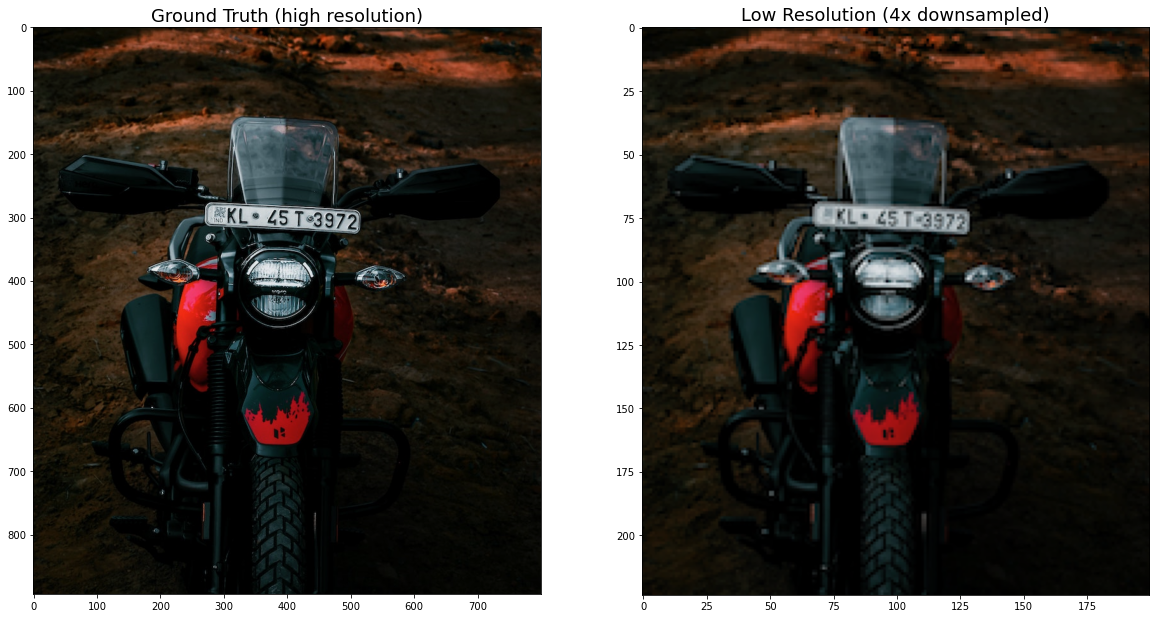

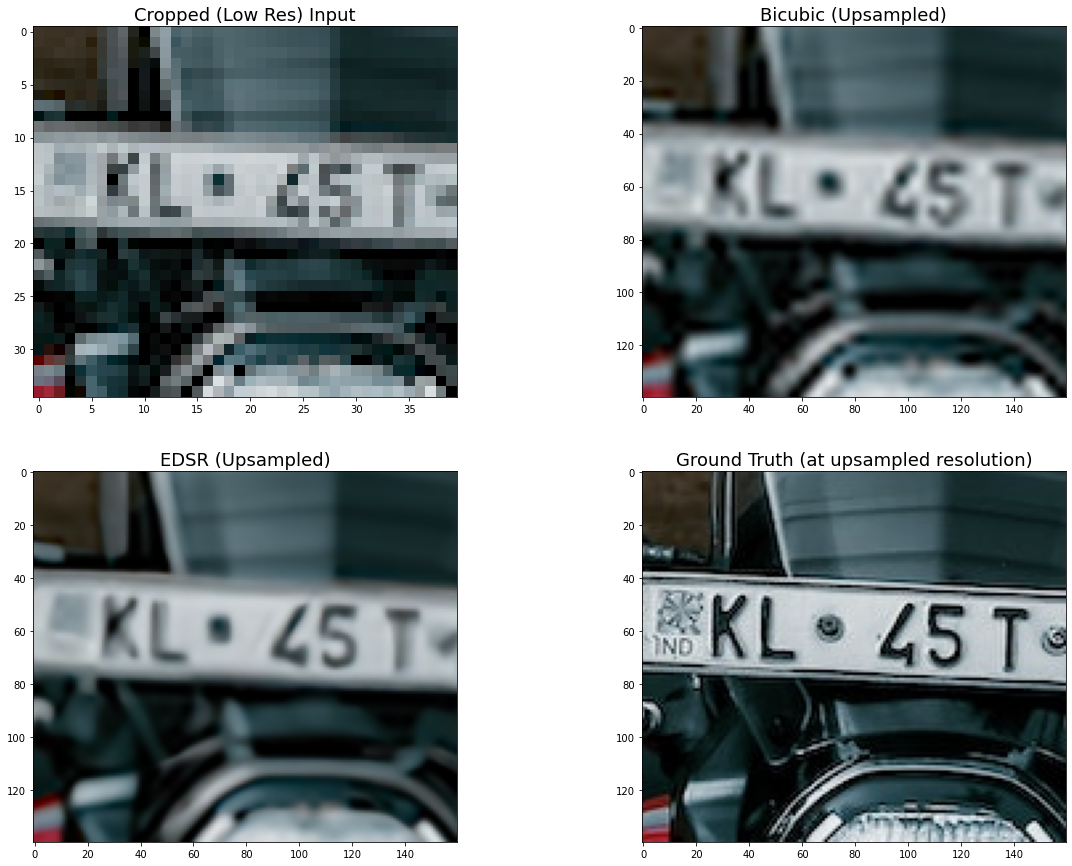

In [14]:
# Read and display the original and cropped image.
bike200 = cv2.imread('bike-200.png')
bike800 = cv2.imread('bike-800.png')
plt.figure(figsize=[20,15])
plt.subplot(1,2,1); plt.imshow(bike800[:,:,::-1]); plt.title('Ground Truth (high resolution)')
plt.subplot(1,2,2); plt.imshow(bike200[:,:,::-1]); plt.title('Low Resolution (4x downsampled)')

# Perform Upscaling and Comparison.
roi = np.array((60,95,70,110))
scale = 4
upsampled_roi = scale*roi
compare_results(bike200, bike800, scale, roi, upsampled_roi)

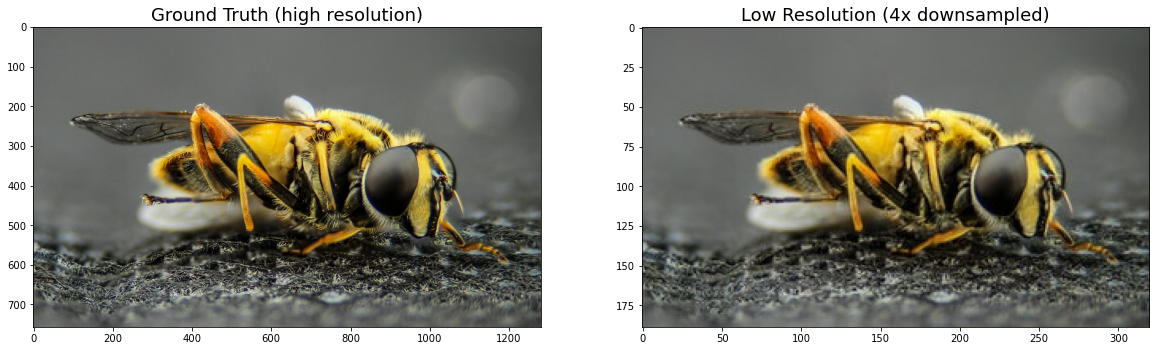

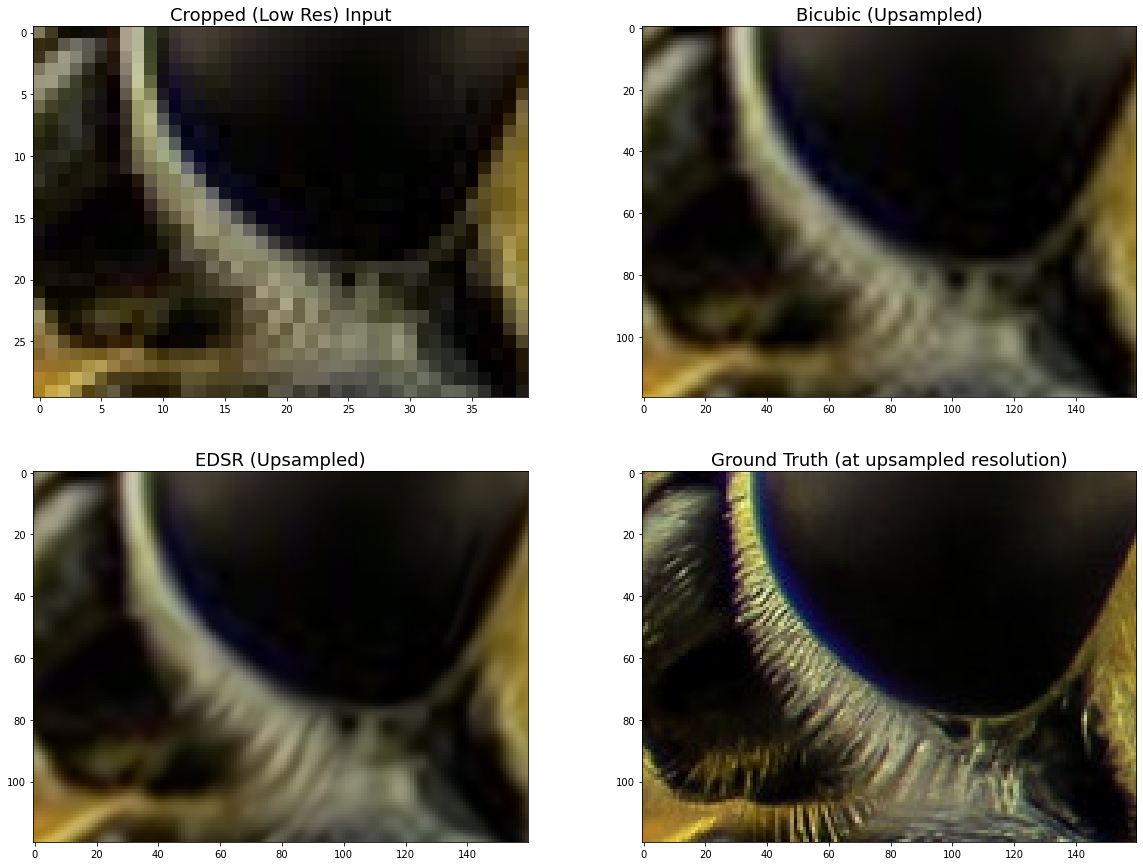

In [15]:
# Read and display the original and cropped image
wasp320 = cv2.imread('wasp-320.jpg')
wasp1280 = cv2.imread('wasp-1280.jpg')
plt.figure(figsize=[20,15])
plt.subplot(1,2,1); plt.imshow(wasp1280[:,:,::-1]); plt.title('Ground Truth (high resolution)')
plt.subplot(1,2,2); plt.imshow(wasp320 [:,:,::-1]); plt.title('Low Resolution (4x downsampled)')

# Perform Upscaling and comparison.
roi = np.array((100,130,200,240))
scale = 4
upsampled_roi = scale*roi
compare_results(wasp320, wasp1280, scale, roi, upsampled_roi)

# 7. Algorithm Runtime Comparison

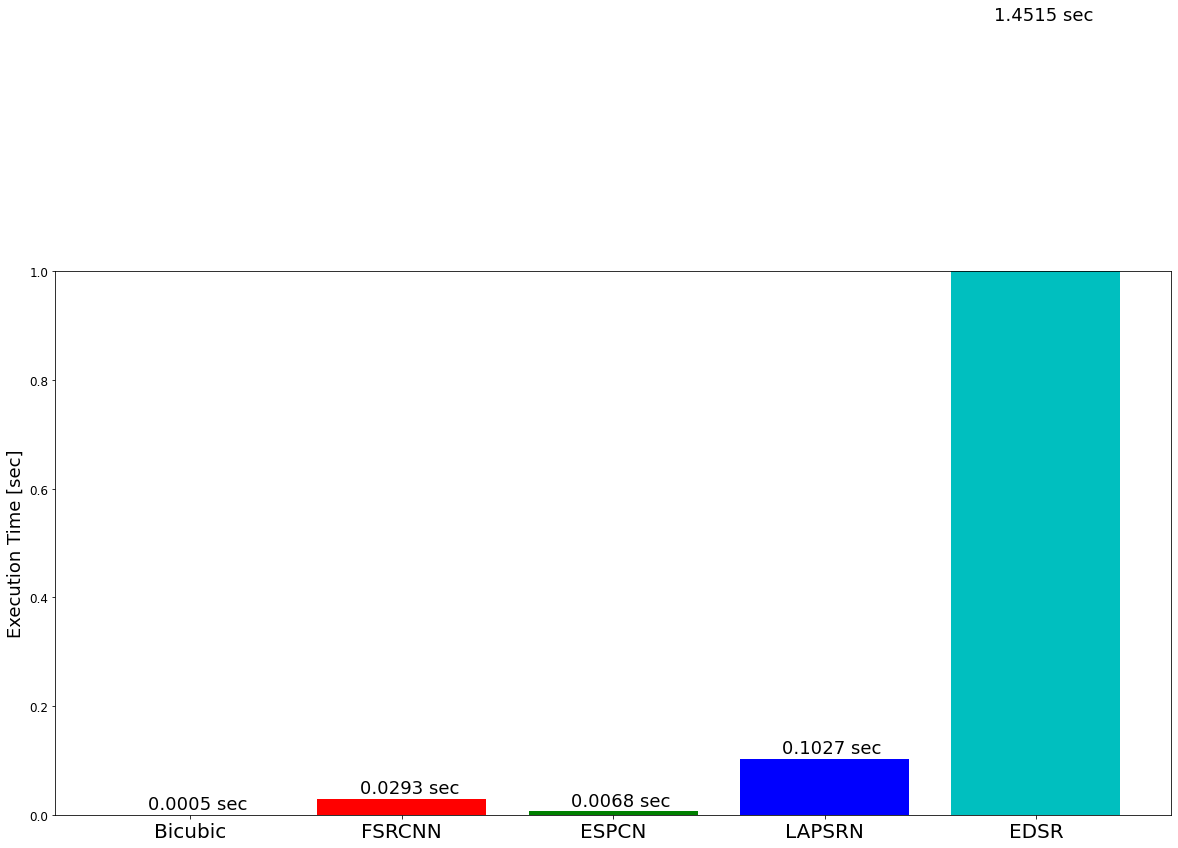

In [16]:
# Initialize accumulators.
totalBicubic = 0
totalEDSR    = 0
totalESPCN   = 0
totalLAPSRN  = 0
totalFSRCNN  = 0

# Set Scale for upsampling.
scale = 4

# Number of iterations for time comparison.
iterations = 10

# Execute each algorithm using the function defined above and keep adding the time to the variable.
for i in range(iterations):
    
    timeBicubic = time.time()
    resultBicubic = cv2.resize(logo_low, None, fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
    totalBicubic += time.time() - timeBicubic    
    
    timeFSRCNN = time.time()
    resultFSRCNN = super_resolve_OpenCV(logo_low, 'FSRCNN', scale)
    totalFSRCNN += time.time() - timeFSRCNN
    
    timeESPCN = time.time()
    resultESPCN = super_resolve_OpenCV(logo_low, 'ESPCN', scale)
    totalESPCN += time.time() - timeESPCN
    
    timeLAPSRN = time.time()
    resultLapSRN = super_resolve_OpenCV(logo_low, 'LapSRN', scale)
    totalLAPSRN += time.time() - timeLAPSRN
    
    timeEDSR = time.time()
    resultEDSR = super_resolve_OpenCV(logo_low, 'EDSR', scale)
    totalEDSR += time.time() - timeEDSR    

# Find average time taken for each algorithm.
avgBicubic = totalBicubic / iterations
avgEDSR = totalEDSR / iterations
avgESPCN = totalESPCN / iterations
avgLAPSRN = totalLAPSRN / iterations
avgFSRCNN = totalFSRCNN / iterations

# Plot them on a bar chart.
plt.figure(figsize=[20,10])

plt.xticks(fontsize=20)
plt.yticks(fontsize=12)

x_axis = ['Bicubic', 'FSRCNN', 'ESPCN', 'LAPSRN', 'EDSR'] 
y_axis = [avgBicubic, avgFSRCNN, avgESPCN, avgLAPSRN, avgEDSR]
plt.bar(x_axis, y_axis, color = ['k', 'r', 'g', 'b', 'c'], align='center')

# Plot the values on top of the bar.
for x, y, p in zip(range(5), y_axis, y_axis):
    plt.text(x - .2, y + .01, '{:.4f} sec'.format(p), fontsize = 18)
    
plt.ylabel('Execution Time [sec]', fontsize = 18); plt.ylim(0,1); plt.show();

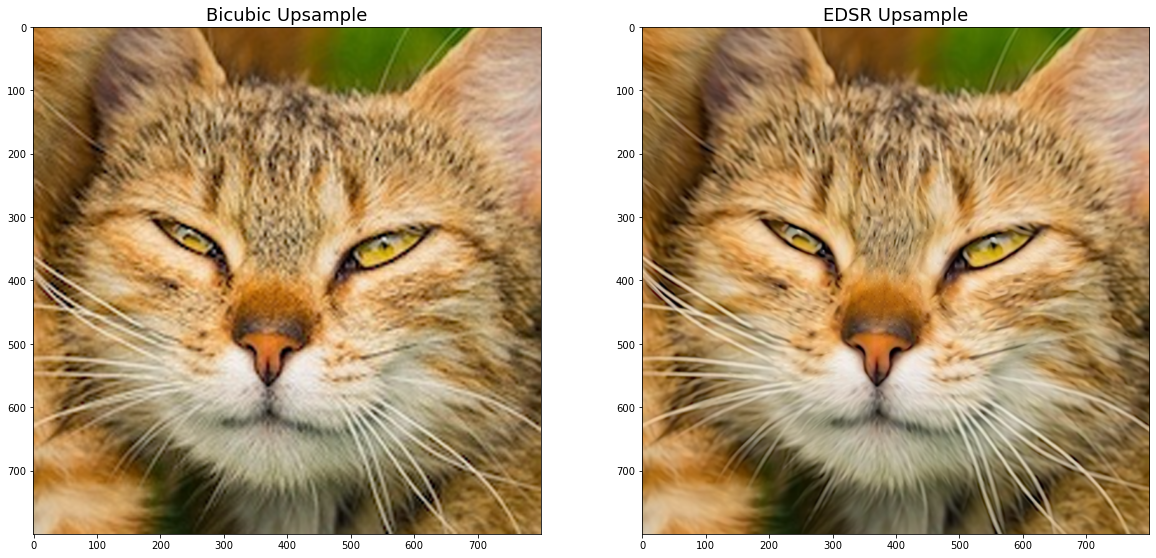

In [17]:
img_kitten = cv2.imread('kitten-200.png')

# Upscale the input image.
kitten_bicubic = cv2.resize(img_kitten, None, fx=4, fy=4, interpolation=cv2.INTER_CUBIC)

# Read the model.
sr.readModel('./models/EDSR_x4.pb')

# Set the model by passing the method and the upsampling scale factor.
sr.setModel('edsr', 4) 

# Upscale the input image.
kitten_edsr= sr.upsample(img_kitten)

plt.figure(figsize=[20,15])
plt.subplot(121); plt.imshow(kitten_bicubic[:,:,::-1]),; plt.title("Bicubic Upsample") 
plt.subplot(122); plt.imshow(kitten_edsr[:,:,::-1]);     plt.title("EDSR Upsample");